In [1]:
import matplotlib.pyplot as plt
import numpy as np
# Make notebook fill the whole screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import time

# Generate Drums

In [2]:
filename = "C:\\Users\\Pascal\\repos\\rbcomb-sample\\RBComb_Millenium\\BottomLayer\\bottom_drumcenters.txt"
centers = []

#buffer file for faster reading
class myFile:
    def __init__(self, filename):
        with open(filename) as file:
            self.lines = file.readlines()
            self.current_line = 0
    
    def end(self):
        return self.current_line >= len(self.lines)
    
    def readline(self):
        if self.end():
            return "\n"
        self.current_line += 1
        return self.lines[self.current_line-1]

    
file = myFile(filename)
centers_read = 0
while(not file.end()):
    line = file.readline()[:-1]
    if(line == ""):
        continue
    else:
        line_split = line.split(" ")
        x = float(line_split[0])
        y = float(line_split[1])
        centers.append(np.array([x, y]))
    centers_read += 1

print(f"Loaded {centers_read} drum centers")

Loaded 1040 drum centers


In [121]:
num_pts = 50
radius = 0.5
center_d0 = np.array([0., 0.])
angles = np.linspace(0, 2.*np.pi, num_pts, endpoint=False)

xy_d0 = np.array([radius*np.cos(angles), radius*np.sin(angles)])
vertices_d0 = [np.array([xy_d0[0,i], xy_d0[1,i]]) for i in range(num_pts)]
elements_d0 = [[0, 1, 2]]
for i in range(3,num_pts):
    elements_d0.append([0, i-1, i])

def create_drum_vertices_and_element_strings(center, index_start):
    vertex_string = ""
    element_string = ""
    for v in vertices_d0:
        vertex_string += f"v {v[0]+center[0]} {v[1]+center[1]} 0.0\n"
    for e in elements_d0:
        element_string += f"f {e[0] + index_start} {e[1] + index_start} {e[2] + index_start}\n"
    return vertex_string, element_string

In [122]:
vertex_string = ""
element_string = ""

starting_index = 0
for i,dc in enumerate(centers):
    new_v_string, new_e_string = create_drum_vertices_and_element_strings(dc, starting_index)
    vertex_string += f"o {i}\n"
    vertex_string += new_v_string
    element_string += new_e_string
    starting_index += num_pts

In [123]:
filename_write = "C:\\Users\\Pascal\\repos\\rbcomb-sample-visualizer\\data_generation\\python\\models\\bottom_drums_single\\bottom_drums.obj"
with open(filename_write, 'w') as file:
    file.write(vertex_string+element_string[:-1])

# Generate Wafer with Drum Cutouts

## Polygonize Wafer

In [3]:
wafer_center = np.array([0., 0.])
wafer_radius = 50. #5cm, 4in wafer

angles = np.linspace(0, 2.*np.pi, 1000, endpoint=False)

In [4]:
wafer_center = np.array([0., 0.])
wafer_radius = 50. #5cm, 4in wafer

angles = np.linspace(0, 2.*np.pi, 1000, endpoint=False)

xy_wafer = np.array([wafer_radius*np.cos(angles), wafer_radius*np.sin(angles)])
vertices_wafer = [np.array([xy_wafer[0,i], xy_wafer[1,i]]) for i in range(1000)]

## Triangulate wafer with cutout drums

### Load fishing holes

In [5]:
filenameFishing = "C:\\Users\\Pascal\\repos\\rbcomb-sample\\BottomLayer\\AutoCAD Scripts\\CreateDevice_Silicon.scr"
myfile = myFile(filenameFishing)
rectangles = []
while not myfile.end():
    if myfile.readline()[:9] == "rectangle":
        line1 = myfile.readline()
        line2 = myfile.readline()
        x0 = float(line1.split(',')[0])
        y0 = float(line1.split(',')[1])
        x1 = float(line2.split(',')[0])
        y1 = float(line2.split(',')[1])
        newRect = [x0, y0, x0, y1, x1, y1, x1, y0]
        rectangles.append(newRect)
print(f"Found {len(rectangles)} rectangles")

Found 544 rectangles


### Build vertex list

In [6]:
#drums with slightly larger radius
#num_pts = 20 #visualizer
num_pts = 50 #blender
radius = 0.51
center_d0 = np.array([0., 0.])
angles = np.linspace(0, 2.*np.pi, num_pts, endpoint=False)

xy_d0 = np.array([radius*np.cos(angles), radius*np.sin(angles)])
vertices_d0 = [np.array([xy_d0[0,i], xy_d0[1,i]]) for i in range(num_pts)]
elements_d0 = [[0, 1, 2]]
for i in range(3,num_pts):
    elements_d0.append([0, i-1, i])

In [7]:
vertices = []
for v in vertices_wafer:
    vertices.append(v[0])
    vertices.append(v[1])
hole_starts = []
for rect in rectangles:
    hole_starts.append(int(len(vertices)/2+0.1))
    for z in rect:
        vertices.append(z)
for dc in centers:
    hole_starts.append(int(len(vertices)/2+0.1))
    for v in vertices_d0:
        vertices.append(v[0]+dc[0])
        vertices.append(v[1]+dc[1])
print(len(vertices))

110352


In [8]:
from earcut import earcut
from copy import copy

In [9]:
start = time.time()
triangles = earcut.earcut(vertices,hole_starts)
end = time.time()
elapsed = end-start
print(f"Elapsed: {elapsed:.5} s")

Elapsed: 2.5634e+04 s


In [10]:
print(f"Number of triangles: {int(len(triangles)/3.+0.1)}")

Number of triangles: 57292


In [30]:
def plot_triangulation(vertices, triangles):
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    for i in range(int(len(triangles)/3.+0.1)):
        js = [triangles[3*i], triangles[3*i+1], triangles[3*i+2]]
        xs = [vertices[2*js[0]], vertices[2*js[1]], vertices[2*js[2]], vertices[2*js[0]]]
        ys = [vertices[2*js[0]+1], vertices[2*js[1]+1], vertices[2*js[2]+1], vertices[2*js[0]+1]]
        ax.plot(xs,ys,c='gray', lw=0.5)

<IPython.core.display.Javascript object>


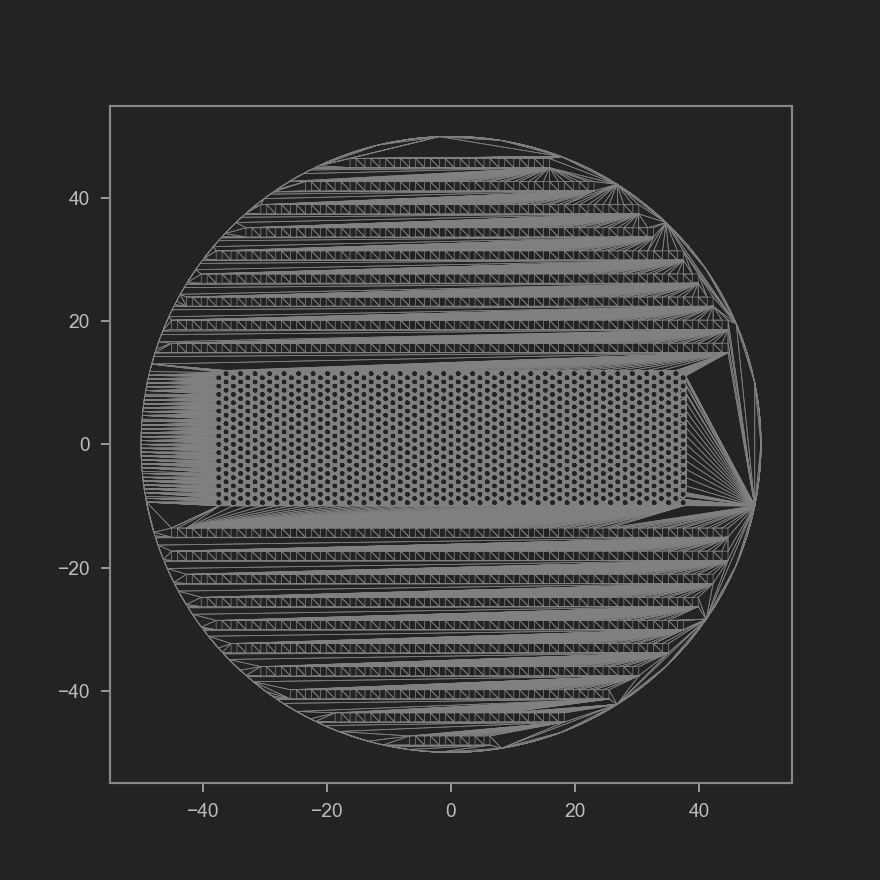

In [231]:
%matplotlib notebook
plot_triangulation(vertices, triangles)

In [11]:
#filename_write = "C:\\Users\\Pascal\\repos\\rbcomb-sample-visualizer\\data_generation\\python\\models\\bottom_silicon_single\\bottom_silicon.obj" #rbcomb viewer
filename_write = "C:\\Users\\Pascal\\repos\\thesis\\images\\Models\\bottom_silicon50.obj" #blender
wafer_string = "o 0\n"
for i in range(int(len(vertices)/2.+0.1)):
    wafer_string += f"v {vertices[2*i]} {vertices[2*i+1]} 0.0\n"
for i in range(int(len(triangles)/3. + 0.1)):
    #wafer_string += f"f {triangles[3*i]} {triangles[3*i+1]} {triangles[3*i+2]}\n" #rbcomb viewer
    wafer_string += f"f {triangles[3*i]+1} {triangles[3*i+1]+1} {triangles[3*i+2]+1}\n" #real .obj
with open(filename_write, 'w') as file:
    file.write(wafer_string[:-1])

<IPython.core.display.Javascript object>


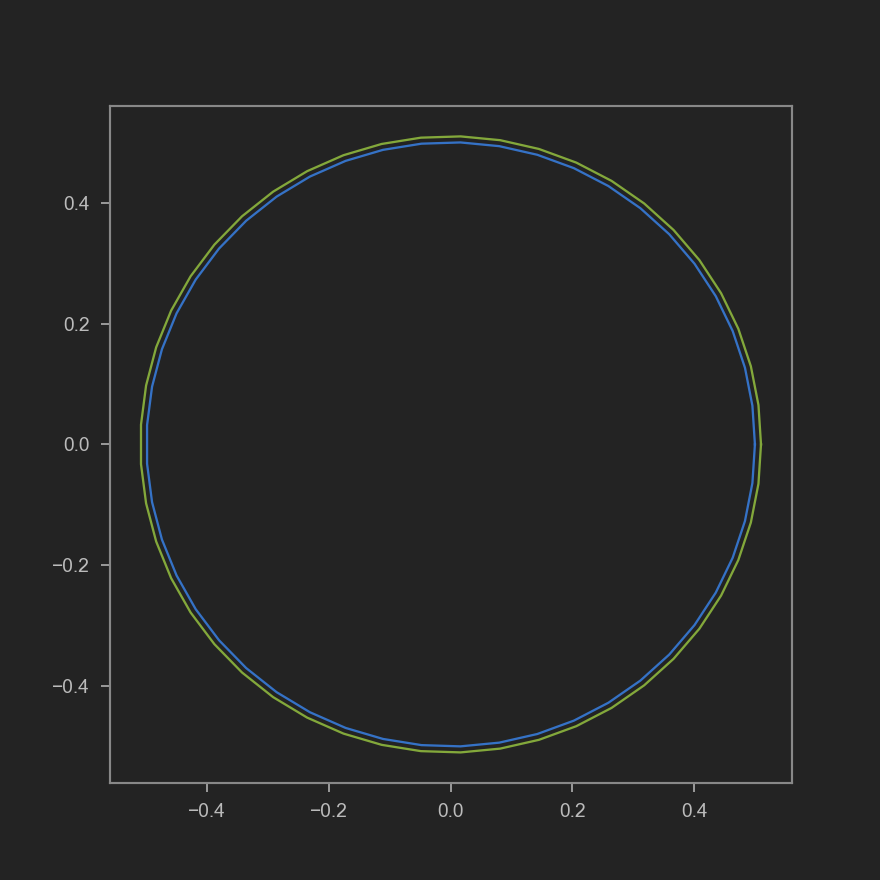

In [49]:
phi_small = np.linspace(0.,2.*np.pi, 50)
phi_big = np.linspace(0.,2.*np.pi, 20)
r_small = 0.5
r_big = 0.51
x_small = r_small * np.cos(phi_small)
y_small = r_small * np.sin(phi_small)
x_big = r_big * np.cos(phi_big)
y_big = r_big * np.sin(phi_big)

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(x_small, y_small)
ax.plot(x_big, y_big)

## Nitride Arms

In [23]:
innerLines = []
innerFile = myFile("C:\\Users\\Pascal\\repos\\rbcomb-sample-visualizer\\data_generation\\python\\arms\\v4rdso2_inner_var18.txt")
newInnerPoints = []
while(not innerFile.end()):
    line = innerFile.readline().rstrip()
    if line == "" or innerFile.end():
        innerLines.append(newInnerPoints)
        newInnerPoints = []
    else:
        newInnerPoints.append(np.array([float(line.split(" ")[0]), float(line.split(" ")[1])]))

In [24]:
outerLines = []
outerFile = myFile("C:\\Users\\Pascal\\repos\\rbcomb-sample-visualizer\\data_generation\\python\\arms\\v4rdso2_outer1_var18.txt")
newOuterPoints = []
while(not outerFile.end()):
    line = outerFile.readline().rstrip()
    if line == "" or outerFile.end():
        outerLines.append(newOuterPoints)
        newOuterPoints = []
    else:
        newOuterPoints.append(np.array([float(line.split(" ")[0]), float(line.split(" ")[1])]))

In [25]:
numPts = 50
phiDrum = np.linspace(0.,2.*np.pi, numPts, endpoint=False)
rDrum = 0.51
xDrum = rDrum * np.cos(phiDrum)
yDrum = rDrum * np.sin(phiDrum)

verticesDrum = []
for i in range(len(xDrum)):
    verticesDrum.append(xDrum[i])
    verticesDrum.append(yDrum[i])

<IPython.core.display.Javascript object>


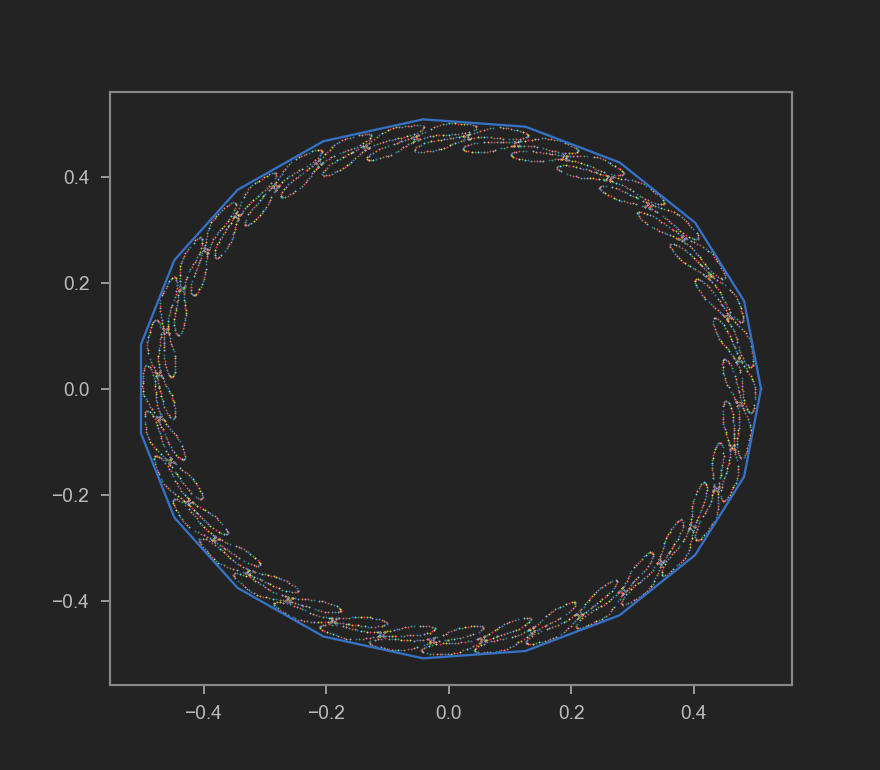

In [186]:
fig, ax = plt.subplots(1,1)
for inner in innerLines:
    for p in inner:
        ax.scatter(p[0], p[1], s=1)
for outer in outerLines:
    for p in outer:
        ax.scatter(p[0], p[1], s=1)

ax.plot(xDrum, yDrum)

In [26]:
print(f"Total Points: {len(innerLines)*len(innerLines[0]) + len(outerLines)*len(outerLines[0])}")

Total Points: 4032


In [27]:
vertices = []
for v in verticesDrum:
    vertices.append(v)
holeStarts = []
for innerLine in innerLines:
    holeStarts.append(int(len(vertices)/2+0.1))
    for i in range(len(innerLine)):
        vertices.append(innerLine[i][0])
        vertices.append(innerLine[i][1])
for outerLine in outerLines:
    holeStarts.append(int(len(vertices)/2+0.1))
    for i in range(len(outerLine)):
        vertices.append(outerLine[i][0])
        vertices.append(outerLine[i][1])
print(len(vertices))

8164


In [28]:
triangles = earcut.earcut(vertices,holeStarts)

<IPython.core.display.Javascript object>


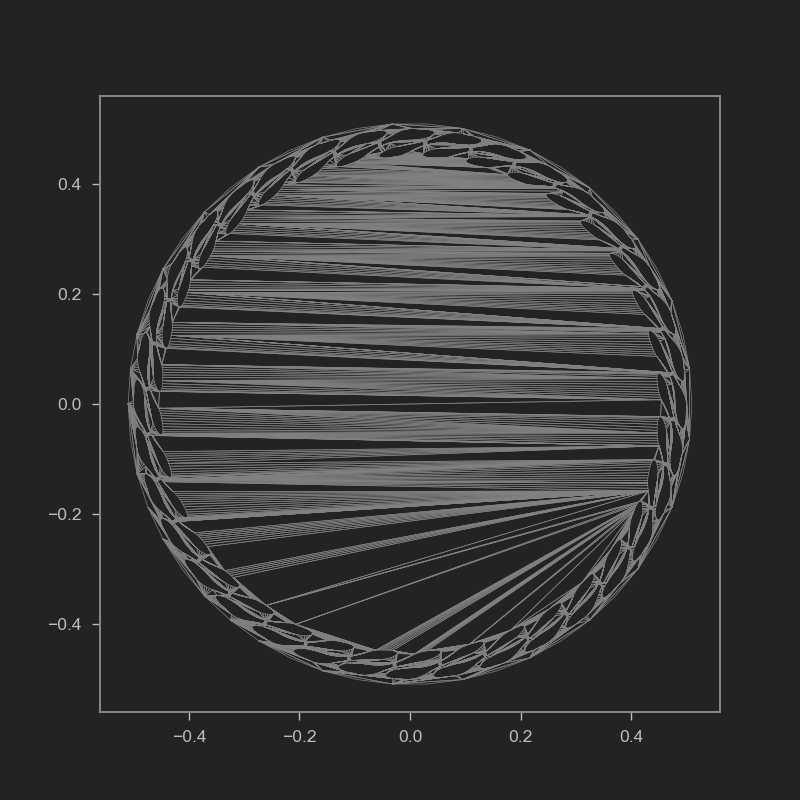

In [31]:
plot_triangulation(vertices, triangles)

In [32]:
filename_write = "C:\\Users\\Pascal\\repos\\thesis\\images\\Models\\bottom_nitride50.obj"

#wafer_string = "o 0\n"
wafer_string = ""
for i in range(int(len(vertices)/2.+0.1)):
    wafer_string += f"v {vertices[2*i]} {vertices[2*i+1]} 0.0\n"
for i in range(int(len(triangles)/3. + 0.1)):
    wafer_string += f"f {triangles[3*i]+1} {triangles[3*i+1]+1} {triangles[3*i+2]+1}\n"

with open(filename_write, 'w') as file:
    file.write(wafer_string[:-1])

### Distribute the drums over the lattice

In [33]:
filename = "C:\\Users\\Pascal\\repos\\rbcomb-sample\\RBComb_Millenium\\BottomLayer\\bottom_drumcenters.txt"
centers = []
file = myFile(filename)
centers_read = 0
while(not file.end()):
    line = file.readline()[:-1]
    if(line == ""):
        continue
    else:
        line_split = line.split(" ")
        x = float(line_split[0])
        y = float(line_split[1])
        centers.append(np.array([x, y]))
    centers_read += 1

print(f"Loaded {centers_read} drum centers")

Loaded 1040 drum centers


In [34]:
offsets = []
numVertices = 0
waferSubstrings = []
for index,c in enumerate(centers):
    wafer_string = f"o {index+1}\n"
    print(f"vertices of drum {index}/{centers_read}")
    offsets.append(numVertices)
    for i in range(int(len(vertices)/2.+0.1)):
        wafer_string += f"v {vertices[2*i]+c[0]} {vertices[2*i+1]+c[1]} 0.0\n"
        numVertices += 1
    waferSubstrings.append(wafer_string)
for index,offs in enumerate(offsets):
    wafer_string = ""
    print(f"triangles of drum {index}/{len(offsets)}")
    for i in range(int(len(triangles)/3. + 0.1)):
        wafer_string += f"f {triangles[3*i]+1+offs} {triangles[3*i+1]+1+offs} {triangles[3*i+2]+1+offs}\n"
    waferSubstrings.append(wafer_string)


#printString = ""
#for i in range(len(waferSubstrings)):
#    printString += waferSubstrings[i]
filename_write = "C:\\Users\\Pascal\\repos\\thesis\\images\\Models\\bottom_nitride50.obj"
with open(filename_write, 'w') as file:
    for i,wss in enumerate(waferSubstrings[:-1]):
        print(f"Writing Substring {i}/{len(waferSubstrings)}")
        file.write(wss)
    file.write(waferSubstrings[-1][:-1])

vertices of drum 0/1040
vertices of drum 1/1040
vertices of drum 2/1040
vertices of drum 3/1040
vertices of drum 4/1040
vertices of drum 5/1040
vertices of drum 6/1040
vertices of drum 7/1040
vertices of drum 8/1040
vertices of drum 9/1040
vertices of drum 10/1040
vertices of drum 11/1040
vertices of drum 12/1040
vertices of drum 13/1040
vertices of drum 14/1040
vertices of drum 15/1040
vertices of drum 16/1040
vertices of drum 17/1040
vertices of drum 18/1040
vertices of drum 19/1040
vertices of drum 20/1040
vertices of drum 21/1040
vertices of drum 22/1040
vertices of drum 23/1040
vertices of drum 24/1040
vertices of drum 25/1040
vertices of drum 26/1040
vertices of drum 27/1040
vertices of drum 28/1040
vertices of drum 29/1040
vertices of drum 30/1040
vertices of drum 31/1040
vertices of drum 32/1040
vertices of drum 33/1040
vertices of drum 34/1040
vertices of drum 35/1040
vertices of drum 36/1040
vertices of drum 37/1040
vertices of drum 38/1040
vertices of drum 39/1040
vertices o

vertices of drum 359/1040
vertices of drum 360/1040
vertices of drum 361/1040
vertices of drum 362/1040
vertices of drum 363/1040
vertices of drum 364/1040
vertices of drum 365/1040
vertices of drum 366/1040
vertices of drum 367/1040
vertices of drum 368/1040
vertices of drum 369/1040
vertices of drum 370/1040
vertices of drum 371/1040
vertices of drum 372/1040
vertices of drum 373/1040
vertices of drum 374/1040
vertices of drum 375/1040
vertices of drum 376/1040
vertices of drum 377/1040
vertices of drum 378/1040
vertices of drum 379/1040
vertices of drum 380/1040
vertices of drum 381/1040
vertices of drum 382/1040
vertices of drum 383/1040
vertices of drum 384/1040
vertices of drum 385/1040
vertices of drum 386/1040
vertices of drum 387/1040
vertices of drum 388/1040
vertices of drum 389/1040
vertices of drum 390/1040
vertices of drum 391/1040
vertices of drum 392/1040
vertices of drum 393/1040
vertices of drum 394/1040
vertices of drum 395/1040
vertices of drum 396/1040
vertices of 

vertices of drum 702/1040
vertices of drum 703/1040
vertices of drum 704/1040
vertices of drum 705/1040
vertices of drum 706/1040
vertices of drum 707/1040
vertices of drum 708/1040
vertices of drum 709/1040
vertices of drum 710/1040
vertices of drum 711/1040
vertices of drum 712/1040
vertices of drum 713/1040
vertices of drum 714/1040
vertices of drum 715/1040
vertices of drum 716/1040
vertices of drum 717/1040
vertices of drum 718/1040
vertices of drum 719/1040
vertices of drum 720/1040
vertices of drum 721/1040
vertices of drum 722/1040
vertices of drum 723/1040
vertices of drum 724/1040
vertices of drum 725/1040
vertices of drum 726/1040
vertices of drum 727/1040
vertices of drum 728/1040
vertices of drum 729/1040
vertices of drum 730/1040
vertices of drum 731/1040
vertices of drum 732/1040
vertices of drum 733/1040
vertices of drum 734/1040
vertices of drum 735/1040
vertices of drum 736/1040
vertices of drum 737/1040
vertices of drum 738/1040
vertices of drum 739/1040
vertices of 

vertices of drum 1019/1040
vertices of drum 1020/1040
vertices of drum 1021/1040
vertices of drum 1022/1040
vertices of drum 1023/1040
vertices of drum 1024/1040
vertices of drum 1025/1040
vertices of drum 1026/1040
vertices of drum 1027/1040
vertices of drum 1028/1040
vertices of drum 1029/1040
vertices of drum 1030/1040
vertices of drum 1031/1040
vertices of drum 1032/1040
vertices of drum 1033/1040
vertices of drum 1034/1040
vertices of drum 1035/1040
vertices of drum 1036/1040
vertices of drum 1037/1040
vertices of drum 1038/1040
vertices of drum 1039/1040
triangles of drum 0/1040
triangles of drum 1/1040
triangles of drum 2/1040
triangles of drum 3/1040
triangles of drum 4/1040
triangles of drum 5/1040
triangles of drum 6/1040
triangles of drum 7/1040
triangles of drum 8/1040
triangles of drum 9/1040
triangles of drum 10/1040
triangles of drum 11/1040
triangles of drum 12/1040
triangles of drum 13/1040
triangles of drum 14/1040
triangles of drum 15/1040
triangles of drum 16/1040
t

triangles of drum 317/1040
triangles of drum 318/1040
triangles of drum 319/1040
triangles of drum 320/1040
triangles of drum 321/1040
triangles of drum 322/1040
triangles of drum 323/1040
triangles of drum 324/1040
triangles of drum 325/1040
triangles of drum 326/1040
triangles of drum 327/1040
triangles of drum 328/1040
triangles of drum 329/1040
triangles of drum 330/1040
triangles of drum 331/1040
triangles of drum 332/1040
triangles of drum 333/1040
triangles of drum 334/1040
triangles of drum 335/1040
triangles of drum 336/1040
triangles of drum 337/1040
triangles of drum 338/1040
triangles of drum 339/1040
triangles of drum 340/1040
triangles of drum 341/1040
triangles of drum 342/1040
triangles of drum 343/1040
triangles of drum 344/1040
triangles of drum 345/1040
triangles of drum 346/1040
triangles of drum 347/1040
triangles of drum 348/1040
triangles of drum 349/1040
triangles of drum 350/1040
triangles of drum 351/1040
triangles of drum 352/1040
triangles of drum 353/1040
t

triangles of drum 682/1040
triangles of drum 683/1040
triangles of drum 684/1040
triangles of drum 685/1040
triangles of drum 686/1040
triangles of drum 687/1040
triangles of drum 688/1040
triangles of drum 689/1040
triangles of drum 690/1040
triangles of drum 691/1040
triangles of drum 692/1040
triangles of drum 693/1040
triangles of drum 694/1040
triangles of drum 695/1040
triangles of drum 696/1040
triangles of drum 697/1040
triangles of drum 698/1040
triangles of drum 699/1040
triangles of drum 700/1040
triangles of drum 701/1040
triangles of drum 702/1040
triangles of drum 703/1040
triangles of drum 704/1040
triangles of drum 705/1040
triangles of drum 706/1040
triangles of drum 707/1040
triangles of drum 708/1040
triangles of drum 709/1040
triangles of drum 710/1040
triangles of drum 711/1040
triangles of drum 712/1040
triangles of drum 713/1040
triangles of drum 714/1040
triangles of drum 715/1040
triangles of drum 716/1040
triangles of drum 717/1040
triangles of drum 718/1040
t

triangles of drum 1001/1040
triangles of drum 1002/1040
triangles of drum 1003/1040
triangles of drum 1004/1040
triangles of drum 1005/1040
triangles of drum 1006/1040
triangles of drum 1007/1040
triangles of drum 1008/1040
triangles of drum 1009/1040
triangles of drum 1010/1040
triangles of drum 1011/1040
triangles of drum 1012/1040
triangles of drum 1013/1040
triangles of drum 1014/1040
triangles of drum 1015/1040
triangles of drum 1016/1040
triangles of drum 1017/1040
triangles of drum 1018/1040
triangles of drum 1019/1040
triangles of drum 1020/1040
triangles of drum 1021/1040
triangles of drum 1022/1040
triangles of drum 1023/1040
triangles of drum 1024/1040
triangles of drum 1025/1040
triangles of drum 1026/1040
triangles of drum 1027/1040
triangles of drum 1028/1040
triangles of drum 1029/1040
triangles of drum 1030/1040
triangles of drum 1031/1040
triangles of drum 1032/1040
triangles of drum 1033/1040
triangles of drum 1034/1040
triangles of drum 1035/1040
triangles of drum 10

Writing Substring 466/2080
Writing Substring 467/2080
Writing Substring 468/2080
Writing Substring 469/2080
Writing Substring 470/2080
Writing Substring 471/2080
Writing Substring 472/2080
Writing Substring 473/2080
Writing Substring 474/2080
Writing Substring 475/2080
Writing Substring 476/2080
Writing Substring 477/2080
Writing Substring 478/2080
Writing Substring 479/2080
Writing Substring 480/2080
Writing Substring 481/2080
Writing Substring 482/2080
Writing Substring 483/2080
Writing Substring 484/2080
Writing Substring 485/2080
Writing Substring 486/2080
Writing Substring 487/2080
Writing Substring 488/2080
Writing Substring 489/2080
Writing Substring 490/2080
Writing Substring 491/2080
Writing Substring 492/2080
Writing Substring 493/2080
Writing Substring 494/2080
Writing Substring 495/2080
Writing Substring 496/2080
Writing Substring 497/2080
Writing Substring 498/2080
Writing Substring 499/2080
Writing Substring 500/2080
Writing Substring 501/2080
Writing Substring 502/2080
W

Writing Substring 771/2080
Writing Substring 772/2080
Writing Substring 773/2080
Writing Substring 774/2080
Writing Substring 775/2080
Writing Substring 776/2080
Writing Substring 777/2080
Writing Substring 778/2080
Writing Substring 779/2080
Writing Substring 780/2080
Writing Substring 781/2080
Writing Substring 782/2080
Writing Substring 783/2080
Writing Substring 784/2080
Writing Substring 785/2080
Writing Substring 786/2080
Writing Substring 787/2080
Writing Substring 788/2080
Writing Substring 789/2080
Writing Substring 790/2080
Writing Substring 791/2080
Writing Substring 792/2080
Writing Substring 793/2080
Writing Substring 794/2080
Writing Substring 795/2080
Writing Substring 796/2080
Writing Substring 797/2080
Writing Substring 798/2080
Writing Substring 799/2080
Writing Substring 800/2080
Writing Substring 801/2080
Writing Substring 802/2080
Writing Substring 803/2080
Writing Substring 804/2080
Writing Substring 805/2080
Writing Substring 806/2080
Writing Substring 807/2080
W

Writing Substring 1099/2080
Writing Substring 1100/2080
Writing Substring 1101/2080
Writing Substring 1102/2080
Writing Substring 1103/2080
Writing Substring 1104/2080
Writing Substring 1105/2080
Writing Substring 1106/2080
Writing Substring 1107/2080
Writing Substring 1108/2080
Writing Substring 1109/2080
Writing Substring 1110/2080
Writing Substring 1111/2080
Writing Substring 1112/2080
Writing Substring 1113/2080
Writing Substring 1114/2080
Writing Substring 1115/2080
Writing Substring 1116/2080
Writing Substring 1117/2080
Writing Substring 1118/2080
Writing Substring 1119/2080
Writing Substring 1120/2080
Writing Substring 1121/2080
Writing Substring 1122/2080
Writing Substring 1123/2080
Writing Substring 1124/2080
Writing Substring 1125/2080
Writing Substring 1126/2080
Writing Substring 1127/2080
Writing Substring 1128/2080
Writing Substring 1129/2080
Writing Substring 1130/2080
Writing Substring 1131/2080
Writing Substring 1132/2080
Writing Substring 1133/2080
Writing Substring 11

Writing Substring 1530/2080
Writing Substring 1531/2080
Writing Substring 1532/2080
Writing Substring 1533/2080
Writing Substring 1534/2080
Writing Substring 1535/2080
Writing Substring 1536/2080
Writing Substring 1537/2080
Writing Substring 1538/2080
Writing Substring 1539/2080
Writing Substring 1540/2080
Writing Substring 1541/2080
Writing Substring 1542/2080
Writing Substring 1543/2080
Writing Substring 1544/2080
Writing Substring 1545/2080
Writing Substring 1546/2080
Writing Substring 1547/2080
Writing Substring 1548/2080
Writing Substring 1549/2080
Writing Substring 1550/2080
Writing Substring 1551/2080
Writing Substring 1552/2080
Writing Substring 1553/2080
Writing Substring 1554/2080
Writing Substring 1555/2080
Writing Substring 1556/2080
Writing Substring 1557/2080
Writing Substring 1558/2080
Writing Substring 1559/2080
Writing Substring 1560/2080
Writing Substring 1561/2080
Writing Substring 1562/2080
Writing Substring 1563/2080
Writing Substring 1564/2080
Writing Substring 15

Writing Substring 1942/2080
Writing Substring 1943/2080
Writing Substring 1944/2080
Writing Substring 1945/2080
Writing Substring 1946/2080
Writing Substring 1947/2080
Writing Substring 1948/2080
Writing Substring 1949/2080
Writing Substring 1950/2080
Writing Substring 1951/2080
Writing Substring 1952/2080
Writing Substring 1953/2080
Writing Substring 1954/2080
Writing Substring 1955/2080
Writing Substring 1956/2080
Writing Substring 1957/2080
Writing Substring 1958/2080
Writing Substring 1959/2080
Writing Substring 1960/2080
Writing Substring 1961/2080
Writing Substring 1962/2080
Writing Substring 1963/2080
Writing Substring 1964/2080
Writing Substring 1965/2080
Writing Substring 1966/2080
Writing Substring 1967/2080
Writing Substring 1968/2080
Writing Substring 1969/2080
Writing Substring 1970/2080
Writing Substring 1971/2080
Writing Substring 1972/2080
Writing Substring 1973/2080
Writing Substring 1974/2080
Writing Substring 1975/2080
Writing Substring 1976/2080
Writing Substring 19

## Generate SU8

In [35]:


numPts = 50
phiSu8 = np.linspace(0.,2.*np.pi, numPts, endpoint=False)
rSu8 = 0.2
xSu8 = rSu8 * np.cos(phiSu8)
ySu8 = rSu8 * np.sin(phiSu8)
verticesSu8 = []
for i in range(len(xSu8)):
    verticesSu8.append(xSu8[i])
    verticesSu8.append(ySu8[i])

### Triangulate

In [36]:
vertices = []
for v in verticesSu8:
    vertices.append(v)
triangles = earcut.earcut(vertices,[])

<IPython.core.display.Javascript object>


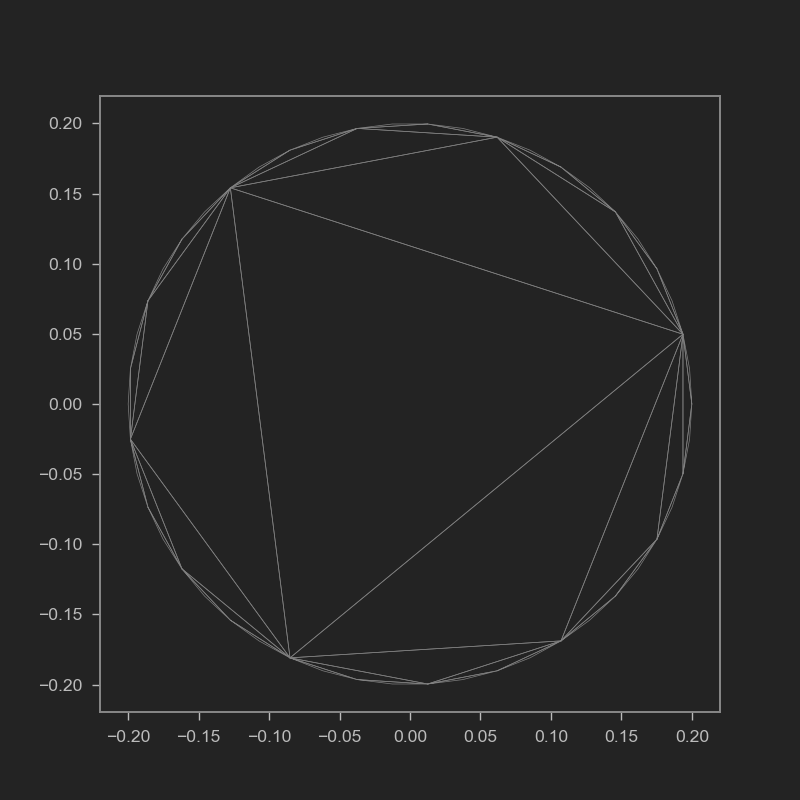

In [37]:
plot_triangulation(vertices, triangles)

### Distribute over wafer

In [38]:
su8File = myFile("C:\\Users\\Pascal\\repos\\rbcomb-sample-visualizer\\data_generation\\python\\CreateDevice_Oxide.scr")
centers = []
while(not su8File.end()):
    if su8File.readline()[:6] == "circle":
        coordline = su8File.readline()
        x = float(coordline.split(',')[0])
        y = float(coordline.split(',')[1])
        centers.append(np.array([x,y]))

print(f"Found {len(centers)} SU8 pillars")

offsets = []
numVertices = 0
waferSubstrings = []
for index,c in enumerate(centers):
    wafer_string = f"o {index+1}\n"
    print(f"vertices of SU8 pillar {index}/{centers_read}")
    offsets.append(numVertices)
    for i in range(int(len(vertices)/2.+0.1)):
        wafer_string += f"v {vertices[2*i]+c[0]} {vertices[2*i+1]+c[1]} 0.0\n"
        numVertices += 1
    waferSubstrings.append(wafer_string)
for index,offs in enumerate(offsets):
    wafer_string = ""
    print(f"triangles of SU8 pillar {index}/{len(offsets)}")
    for i in range(int(len(triangles)/3. + 0.1)):
        wafer_string += f"f {triangles[3*i]+1+offs} {triangles[3*i+1]+1+offs} {triangles[3*i+2]+1+offs}\n"
    waferSubstrings.append(wafer_string)

filename_write = "C:\\Users\\Pascal\\repos\\thesis\\images\\Models\\bottom_su850.obj"
with open(filename_write, 'w') as file:
    for i,wss in enumerate(waferSubstrings[:-1]):
        print(f"Writing Substring {i}/{len(waferSubstrings)}")
        file.write(wss)
    file.write(waferSubstrings[-1][:-1])

Found 1642 SU8 pillars
vertices of SU8 pillar 0/1040
vertices of SU8 pillar 1/1040
vertices of SU8 pillar 2/1040
vertices of SU8 pillar 3/1040
vertices of SU8 pillar 4/1040
vertices of SU8 pillar 5/1040
vertices of SU8 pillar 6/1040
vertices of SU8 pillar 7/1040
vertices of SU8 pillar 8/1040
vertices of SU8 pillar 9/1040
vertices of SU8 pillar 10/1040
vertices of SU8 pillar 11/1040
vertices of SU8 pillar 12/1040
vertices of SU8 pillar 13/1040
vertices of SU8 pillar 14/1040
vertices of SU8 pillar 15/1040
vertices of SU8 pillar 16/1040
vertices of SU8 pillar 17/1040
vertices of SU8 pillar 18/1040
vertices of SU8 pillar 19/1040
vertices of SU8 pillar 20/1040
vertices of SU8 pillar 21/1040
vertices of SU8 pillar 22/1040
vertices of SU8 pillar 23/1040
vertices of SU8 pillar 24/1040
vertices of SU8 pillar 25/1040
vertices of SU8 pillar 26/1040
vertices of SU8 pillar 27/1040
vertices of SU8 pillar 28/1040
vertices of SU8 pillar 29/1040
vertices of SU8 pillar 30/1040
vertices of SU8 pillar 31/

vertices of SU8 pillar 1336/1040
vertices of SU8 pillar 1337/1040
vertices of SU8 pillar 1338/1040
vertices of SU8 pillar 1339/1040
vertices of SU8 pillar 1340/1040
vertices of SU8 pillar 1341/1040
vertices of SU8 pillar 1342/1040
vertices of SU8 pillar 1343/1040
vertices of SU8 pillar 1344/1040
vertices of SU8 pillar 1345/1040
vertices of SU8 pillar 1346/1040
vertices of SU8 pillar 1347/1040
vertices of SU8 pillar 1348/1040
vertices of SU8 pillar 1349/1040
vertices of SU8 pillar 1350/1040
vertices of SU8 pillar 1351/1040
vertices of SU8 pillar 1352/1040
vertices of SU8 pillar 1353/1040
vertices of SU8 pillar 1354/1040
vertices of SU8 pillar 1355/1040
vertices of SU8 pillar 1356/1040
vertices of SU8 pillar 1357/1040
vertices of SU8 pillar 1358/1040
vertices of SU8 pillar 1359/1040
vertices of SU8 pillar 1360/1040
vertices of SU8 pillar 1361/1040
vertices of SU8 pillar 1362/1040
vertices of SU8 pillar 1363/1040
vertices of SU8 pillar 1364/1040
vertices of SU8 pillar 1365/1040
vertices o

Writing Substring 313/3284
Writing Substring 314/3284
Writing Substring 315/3284
Writing Substring 316/3284
Writing Substring 317/3284
Writing Substring 318/3284
Writing Substring 319/3284
Writing Substring 320/3284
Writing Substring 321/3284
Writing Substring 322/3284
Writing Substring 323/3284
Writing Substring 324/3284
Writing Substring 325/3284
Writing Substring 326/3284
Writing Substring 327/3284
Writing Substring 328/3284
Writing Substring 329/3284
Writing Substring 330/3284
Writing Substring 331/3284
Writing Substring 332/3284
Writing Substring 333/3284
Writing Substring 334/3284
Writing Substring 335/3284
Writing Substring 336/3284
Writing Substring 337/3284
Writing Substring 338/3284
Writing Substring 339/3284
Writing Substring 340/3284
Writing Substring 341/3284
Writing Substring 342/3284
Writing Substring 343/3284
Writing Substring 344/3284
Writing Substring 345/3284
Writing Substring 346/3284
Writing Substring 347/3284
Writing Substring 348/3284
Writing Substring 349/3284
W